In [9]:
import os
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

imgs = []
boxes = []
for img_path in glob('dataset/test/images/*.jpg'):
    # read image
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3,ratio=4)
    img = tf.image.convert_image_dtype(img,tf.float32)
    imgs.append(img)
    label_path = img_path.replace('/images','/labels').replace('.jpg','.txt')
    labels = np.loadtxt(label_path,delimiter=' ')
    centers = labels[:,[2,1]] # TensorFlow API wants yx
    widths = labels[:,[4,3]] # TensorFlow API wants yx
    boxes.append( tf.convert_to_tensor(np.hstack([centers-0.5*widths,centers+0.5*widths]), tf.float32) )

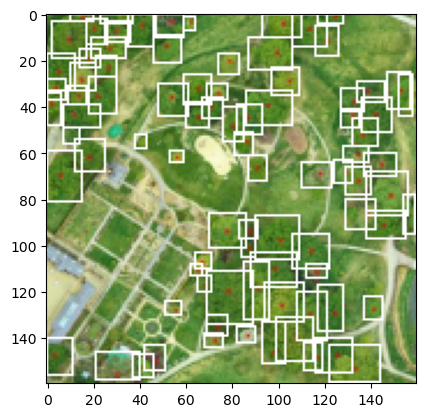

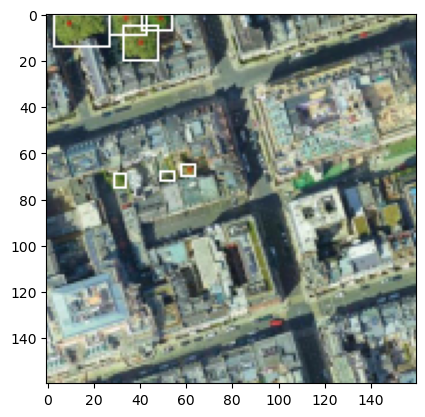

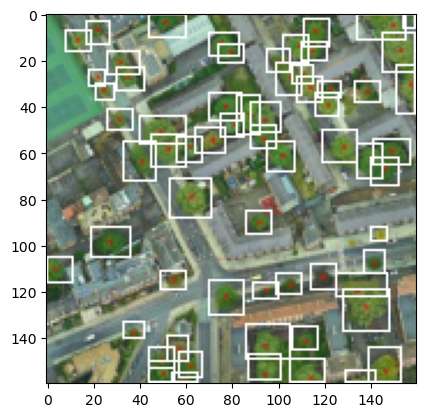

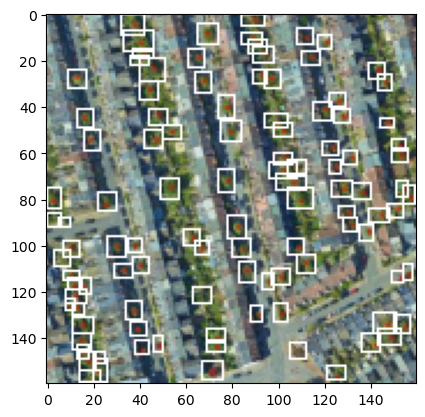

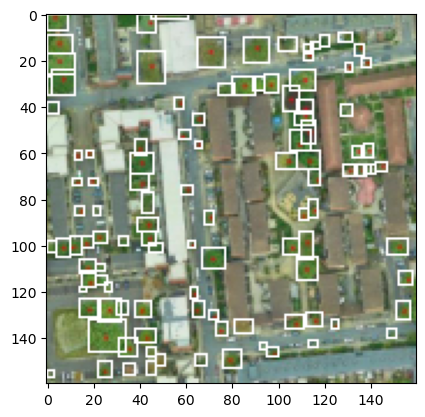

In [10]:
imgs = tf.stack(imgs)
# boxes require pading...
max_bboxes = max(b.shape[0] for b in boxes)
boxes = [tf.pad(b, tf.constant([[0,max_bboxes-len(b)], [0,0]])) for b in boxes]
# .. and then can be stacked too
boxes = tf.stack(boxes)
colors = np.array([[1.0, 1.0, 1.0]])
count=0
for img in tf.image.draw_bounding_boxes(imgs,boxes,colors):
    if(count==5):
        break
    plt.imshow(img.numpy())
    plt.show()
    count=count+1

In [7]:
#preprocessing
import numpy as np
import tensorflow as tf
from glob import glob

IMG_SIZE = (256,256)

def gen_example(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    #print(img_path)
    label_path = img_path.replace('/images','/labels').replace('.jpg','.txt')
    #print(label_path)
    labels = np.loadtxt(label_path,delimiter=' ')
    label_wh = labels[:,[3,4]]
    label_xy = labels[:,[1,2]]
    boxes = np.hstack([label_xy-0.5*label_wh,label_xy+0.5*label_wh])
    boxes = boxes*(img.shape[:2]+img.shape[:2])
    K_loc = 0.5*(boxes[:,[2,3]]+boxes[:,[0,1]])
    K_bw = 0.5*(boxes[:,[2,3]]-boxes[:,[0,1]])
    ys, xs = np.ogrid[0:img.shape[0]:IMG_SIZE[0]*1j, 0:img.shape[1]:IMG_SIZE[1]*1j]
    dens = 0
    for (loc_x,loc_y),(bw_x,bw_y) in zip(K_loc,K_bw):
        bw_x, bw_y = 10,10 # use constant rather than actual size for simplicity
        dens_update = np.clip(1-np.abs(loc_x-xs)/bw_x,0,1)*np.clip(1-np.abs(loc_y-ys)/bw_y,0,1)
        dens = dens + dens_update
    return img,dens


def gen_data(subpath='train'):
    def gen():
        for img_path in glob(f'dataset/{subpath}/images/*.jpg'):
            img,dens = gen_example(img_path)
            yield img,dens
    return gen


train_ds = tf.data.Dataset.from_generator(
     gen_data('train'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
train_ds = train_ds.shuffle(100).batch(32).prefetch(1).cache()

val_ds = tf.data.Dataset.from_generator(
     gen_data('valid'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
val_ds = val_ds.shuffle(1000).batch(32).prefetch(1).cache()

test_ds = tf.data.Dataset.from_generator(
     gen_data('test'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
test_ds = test_ds.batch(32).prefetch(1).cache()

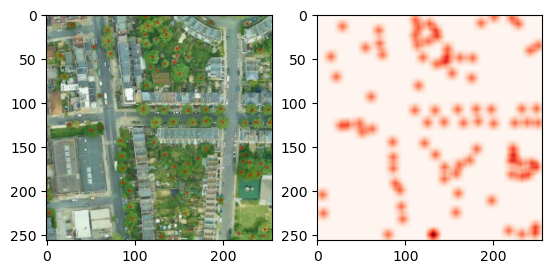

In [11]:
import matplotlib.pyplot as plt

img,dens = next(train_ds.unbatch().as_numpy_iterator())
fig,axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(dens,cmap="Reds")
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

input_shape = IMG_SIZE + (3,)

def get_new_model():

    model = tf.keras.Sequential([

        layers.Conv2D(32,kernel_size=10, strides=1,input_shape=input_shape, padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=3,strides=2,padding='same'),

        layers.Conv2D(64,kernel_size=3, padding='same'),
        layers.Activation('relu'),
        layers.Conv2D(64,kernel_size=3, padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=3,strides=2,padding='same'),

        layers.Conv2D(1,kernel_size=3, padding='same'),
        layers.Activation('relu'),

        layers.UpSampling2D(size=(4,4), interpolation='bilinear'),
    ]
    )


    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),)
    
    return model

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      9632      
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      36928     
                                                        

Epoch 1/500
2/2 [==============================] - 26s 12s/step - loss: 0.0579 - val_loss: 0.0552
Epoch 2/500
2/2 [==============================] - 19s 10s/step - loss: 0.0563 - val_loss: 0.0547
Epoch 3/500
2/2 [==============================] - 19s 10s/step - loss: 0.0559 - val_loss: 0.0537
Epoch 4/500
2/2 [==============================] - 18s 10s/step - loss: 0.0547 - val_loss: 0.0531
Epoch 5/500
2/2 [==============================] - 19s 10s/step - loss: 0.0539 - val_loss: 0.0526
Epoch 6/500
2/2 [==============================] - 21s 11s/step - loss: 0.0532 - val_loss: 0.0519
Epoch 7/500
2/2 [==============================] - 26s 14s/step - loss: 0.0523 - val_loss: 0.0512
Epoch 8/500
2/2 [==============================] - 21s 12s/step - loss: 0.0516 - val_loss: 0.0505
Epoch 9/500
2/2 [==============================] - 26s 14s/step - loss: 0.0509 - val_loss: 0.0499
Epoch 10/500
2/2 [==============================] - 24s 13s/step - loss: 0.0503 - val_loss: 0.0494
Epoch 11/500
2/2 [=

2/2 [==============================] - 18s 10s/step - loss: 0.0273 - val_loss: 0.0266
Epoch 85/500
2/2 [==============================] - 18s 9s/step - loss: 0.0271 - val_loss: 0.0263
Epoch 86/500
2/2 [==============================] - 18s 9s/step - loss: 0.0268 - val_loss: 0.0260
Epoch 87/500
2/2 [==============================] - 18s 10s/step - loss: 0.0265 - val_loss: 0.0257
Epoch 88/500
2/2 [==============================] - 18s 9s/step - loss: 0.0263 - val_loss: 0.0254
Epoch 89/500
2/2 [==============================] - 17s 9s/step - loss: 0.0260 - val_loss: 0.0251
Epoch 90/500
2/2 [==============================] - 18s 9s/step - loss: 0.0257 - val_loss: 0.0248
Epoch 91/500
2/2 [==============================] - 18s 10s/step - loss: 0.0254 - val_loss: 0.0245
Epoch 92/500
2/2 [==============================] - 18s 9s/step - loss: 0.0251 - val_loss: 0.0242
Epoch 93/500
2/2 [==============================] - 17s 9s/step - loss: 0.0248 - val_loss: 0.0239
Epoch 94/500
2/2 [============

Epoch 167/500
2/2 [==============================] - 17s 9s/step - loss: 0.0159 - val_loss: 0.0151
Epoch 168/500
2/2 [==============================] - 17s 9s/step - loss: 0.0159 - val_loss: 0.0150
Epoch 169/500
2/2 [==============================] - 18s 9s/step - loss: 0.0158 - val_loss: 0.0150
Epoch 170/500
2/2 [==============================] - 18s 10s/step - loss: 0.0158 - val_loss: 0.0150
Epoch 171/500
2/2 [==============================] - 18s 9s/step - loss: 0.0158 - val_loss: 0.0149
Epoch 172/500
2/2 [==============================] - 18s 10s/step - loss: 0.0157 - val_loss: 0.0149
Epoch 173/500
2/2 [==============================] - 18s 9s/step - loss: 0.0157 - val_loss: 0.0149
Epoch 174/500
2/2 [==============================] - 17s 9s/step - loss: 0.0157 - val_loss: 0.0149
Epoch 175/500
2/2 [==============================] - 18s 9s/step - loss: 0.0157 - val_loss: 0.0148
Epoch 176/500
2/2 [==============================] - 18s 9s/step - loss: 0.0156 - val_loss: 0.0148
Epoch 17

2/2 [==============================] - 18s 9s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 332/500
2/2 [==============================] - 18s 9s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 333/500
2/2 [==============================] - 18s 10s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 334/500
2/2 [==============================] - 17s 9s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 335/500
2/2 [==============================] - 17s 9s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 336/500
2/2 [==============================] - 17s 9s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 337/500
2/2 [==============================] - 18s 10s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 338/500
2/2 [==============================] - 18s 9s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 339/500
2/2 [==============================] - 18s 9s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 340/500
2/2 [==============================] - 18s 9s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 341/500
2/2 [===

2/2 [==============================] - 18s 9s/step - loss: 0.0130 - val_loss: 0.0122
Epoch 496/500
2/2 [==============================] - 18s 10s/step - loss: 0.0130 - val_loss: 0.0122
Epoch 497/500
2/2 [==============================] - 24s 13s/step - loss: 0.0130 - val_loss: 0.0122
Epoch 498/500
2/2 [==============================] - 20s 11s/step - loss: 0.0130 - val_loss: 0.0122
Epoch 499/500
2/2 [==============================] - 18s 10s/step - loss: 0.0130 - val_loss: 0.0122
Epoch 500/500
2/2 [==============================] - 18s 10s/step - loss: 0.0130 - val_loss: 0.0122


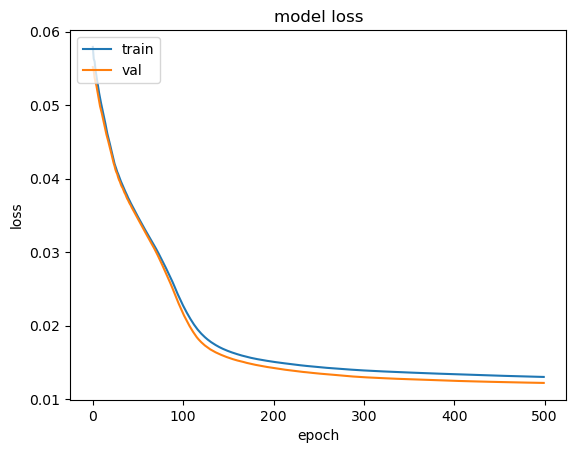

In [13]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,validation_data=val_ds,epochs=1000,callbacks=[early_stopper])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
model.save_weights('model.h5')
model.save('treesense.h5')
